In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from skimage.transform import resize
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Project3 

/content/drive/MyDrive/Project3


In [4]:
!nvidia-smi

Wed Nov 24 07:28:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Loading data

In [5]:
X_train = torch.load('datasets/X_train')
X_test = torch.load('datasets/X_test')
y_train = torch.load('datasets/y_train')
y_test = torch.load('datasets/y_test')
X_val = torch.load('datasets/X_val')
y_val = torch.load('datasets/y_val')

In [6]:
def convertDataloader(X1,y_train):
    batch_size = 64
    train_data = TensorDataset(X1,y_train)
    train_sampler = SequentialSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return train_dataloader

In [7]:
def setDataloader(X_train,X_test,y_train,y_test,X_val,y_val):
    X1_train = torch.tensor(X_train)
    X1_test = torch.tensor(X_test)
    X1_val = torch.tensor(X_val)
    y_train = torch.tensor(y_train)
    y_test = torch.tensor(y_test)
    y_val = torch.tensor(y_val)

    train_dataloader = convertDataloader(X1_train,y_train)
    test_dataloader = convertDataloader(X1_test,y_test)
    val_dataloader = convertDataloader(X1_val,y_val)
    return train_dataloader,test_dataloader,val_dataloader

Convert dataloader with a batch: 64

In [8]:
train_dataloader,test_dataloader,val_dataloader = setDataloader(X_train,X_test,y_train,y_test,X_val,y_val)

Training model

In [9]:
def predict_evalation(net,criterion,data_dataloader):
    loss_val = 0
    net.eval()
    with torch.no_grad():
        y_pred = []
        y_true = []
        for i, batch in tqdm_notebook(enumerate(data_dataloader)):
            net.zero_grad()

            input1 = batch[0].to(device)
            
            y = batch[1].to(device)
            output = net(input1)

            loss = criterion(output, y.long())
            loss_val += loss.item()
            
            y_direc = torch.argmax(output,dim = 1)
            y_pred+= y_direc.cpu()
            y_true+=y.cpu()
        score = accuracy_score(y_true, y_pred)
    return score,loss_val

In [10]:
from tqdm import tqdm_notebook


# Keep track of losses for plotting


from sklearn.metrics import accuracy_score
def trainEpoch(net,criterion,net_optimizer,train_dataloader,test_dataloader,val_dataloader,accTrain,accVal,accTest,bestScore,lossTrain,lossVal,lossTest,epochs=100):
  
    # bestScore = 0
    print(bestScore)


    for epoch in range(epochs):
        print('-'*40)
        print('Epoch:',epoch)
        net.train()
        y_pred = []
        y_true = []
        # train_dataloader,val_dataloader = setDataloader(X_train,X_test,y_train,y_test)

        loss_train = 0
        for i, batch in tqdm_notebook(enumerate(train_dataloader)):
            net.zero_grad()

            input1 = batch[0].to(device)
            

            y = batch[1].to(device)
            output = net(input1)
            loss = criterion(output, y.long())
            loss.backward()
            net_optimizer.step()
            loss_train += loss.item()

            y_direc = torch.argmax(output,dim = 1)
            y_pred+= y_direc.cpu()
            y_true+=y.cpu()

        
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        score_train = accuracy_score(y_true, y_pred)
        print("Train Accuracy: ",score_train)
        print('Loss Accuracy: ',loss_train)

        accTrain.append(score_train)
        lossTrain.append(loss_train)

        score_val,loss_val = predict_evalation(net,criterion,val_dataloader)
        print("Validation Accuracy: ",score_val)
        print('Loss Validation: ',loss_val)

        accVal.append(score_val)
        lossVal.append(loss_val)

        score_test,loss_test = predict_evalation(net,criterion,test_dataloader)
        print("Test Accuracy: ",score_test)
        print('Loss Test: ',loss_test)

        accTest.append(score_test)
        lossTest.append(loss_test)



    #     if(score_test > bestScore):
    #         bestScore = score_test
    #         print('Best score:',bestScore)
    #         torch.save({
    #           'epoch': epoch,
    #           'model_state_dict': net.state_dict(),
    #           'optimizer_state_dict': net_optimizer.state_dict(),
    #           'best_score': bestScore
    #           }, 'weights/bestModel.pth')


    # torch.save({
    #     'acc_train':accTrain,
    #     'acc_val':accVal,
    #     'acc_test':accTest,
    #     'lossTrain':lossTrain,
    #     'lossVal':lossVal,
    #     'lossTest':lossTest
    # },'weights/datail_information.pth')
      
    return 0



In [11]:
from torch import optim

Architecture of model

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.pool1 = nn.MaxPool2d(kernel_size=3,stride=1)

        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool2 = nn.MaxPool2d(kernel_size=3,stride=1)

        self.conv3 = nn.Conv2d(64, 128, 5, 1)
        self.pool3 = nn.MaxPool2d(kernel_size=3,stride=1)

        self.conv4 = nn.Conv2d(128, 256, 5, 1)
        self.pool4 = nn.MaxPool2d(kernel_size=3,stride=1)

        self.conv5 = nn.Conv2d(256, 256, 5, 1)
        self.pool5 = nn.MaxPool2d(kernel_size=2,stride=2)


        self.dropout = nn.Dropout(0.1)


        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 10)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = nn.functional.normalize(x1)
        x1 = self.pool1(F.relu(x1))
        x1 = self.dropout(x1)

        x2 = self.conv2(x1)
        x2 = nn.functional.normalize(x2)
        x2 = self.pool2(F.relu(x2))
        x2 = self.dropout(x2)

        x3 = self.conv3(x2)
        x3 = nn.functional.normalize(x3)
        x3 = self.pool3(F.relu(x3))
        x3 = self.dropout(x3)

        x4 = self.conv4(x3)
        x4 = nn.functional.normalize(x4)
        x4 = self.pool4(F.relu(x4))
        x4 = self.dropout(x4)

        x5 = self.conv5(x4)
        x5 = nn.functional.normalize(x5)
        x5 = self.pool5(F.relu(x5))
        x5 = self.dropout(x5)

        x6 = torch.flatten(x5, 1)
        # print(x6.shape)

        out = self.fc1(x6)
        out = F.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        output = self.logSoftmax(out)
        return output

Initialize parameter: optim, criterion

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
net = Net().to(device)
net_optimizer = optim.Adam(lr=0.001,params= net.parameters())

In [14]:
summary(net,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
         MaxPool2d-2           [-1, 32, 24, 24]               0
           Dropout-3           [-1, 32, 24, 24]               0
            Conv2d-4           [-1, 64, 22, 22]          18,496
         MaxPool2d-5           [-1, 64, 20, 20]               0
           Dropout-6           [-1, 64, 20, 20]               0
            Conv2d-7          [-1, 128, 16, 16]         204,928
         MaxPool2d-8          [-1, 128, 14, 14]               0
           Dropout-9          [-1, 128, 14, 14]               0
           Conv2d-10          [-1, 256, 10, 10]         819,456
        MaxPool2d-11            [-1, 256, 8, 8]               0
          Dropout-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 4, 4]       1,638,656
        MaxPool2d-14            [-1, 25

In [15]:
accTrain = []
accVal = []
accTest = []
bestScore = 0
lossTrain = []
lossTest = []
lossVal = []

**Load data** when the training is finished

In [16]:
def load_data_train(net):
    checkPointInfor = torch.load('weights/datail_information.pth')
    checkPointModel = torch.load('weights/bestModel.pth')
    accTrain = checkPointInfor['acc_train']
    accVal = checkPointInfor['acc_val']
    accTest = checkPointInfor['acc_test']
    lossTrain = checkPointInfor['lossTrain']
    lossTest = checkPointInfor['lossTest']
    lossVal = checkPointInfor['lossVal']
    net.load_state_dict(checkPointModel['model_state_dict'])
    bestScore = checkPointModel['best_score']
    return accTrain,accVal,accTest,bestScore,lossTrain,lossVal,lossTest

In [17]:
accTrain,accVal,accTest,bestScore,lossTrain,lossVal,lossTest = load_data_train(net)

In [ ]:
trainEpoch(net,criterion,net_optimizer,train_dataloader,test_dataloader,val_dataloader,accTrain,accVal,accTest,bestScore,lossTrain,lossVal,lossTest,epochs=50)

In [18]:
score_test,loss_test = predict_evalation(net,criterion,test_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


0it [00:00, ?it/s]

In [19]:
bestScore

0.9948

In [20]:
print('Test Accuracy:',score_test)

Test Accuracy: 0.9948


In [21]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

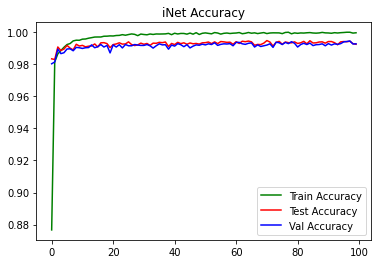

In [26]:
# figure(figsize=(15, 10), dpi=80)
plt.plot(accTrain,'g',label='Train Accuracy')
plt.plot(accTest,'r',label='Test Accuracy')
plt.plot(accVal,'b',label='Val Accuracy')
plt.title('iNet Accuracy')
plt.legend()
plt.savefig('./Image/accuracy.png')

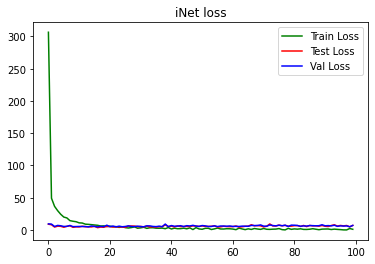

In [27]:
# figure(figsize=(15, 8), dpi=80)

plt.plot(lossTrain,'g',label='Train Loss')
plt.plot(lossTest,'r',label='Test Loss')
plt.plot(lossVal,'b',label='Val Loss')
plt.title('iNet loss')
plt.legend()
plt.savefig('./Image/loss.png')